# installation

In [1]:
!pip install scikit-image pandas matplotlib tqdm  torchinfo tensorboard wandb scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


# Custom PyTorch Dataset

In [2]:
import os
import wandb
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_sched
from torchinfo import summary
import torch.optim as optim
import random
import math
from tqdm import tqdm
import psutil


from typing import Dict

# metrics
from sklearn.metrics import roc_auc_score, accuracy_score

# Config

In [3]:
class CONFIG:
    BATCH_SIZE = 16
    
    # limit the data to prototype faster
    DATA_LIMIT = 0
    
    CLASSES = 3
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ROUND_NUMBER = 3
    TASK_NAME = "DeepLense2024_task1"

In [4]:
def format(val : int) -> str:
    if val <= 1024:
        return f"{val}B"
    elif val <= 1024**2:
        return f"{round(val/1024, 2)}KB" 
    elif val <= 1024**3:
        return f"{round(val/(1024**2), 2)}MB" 
    return f"{round(val / (1024**3), 2)}GB"
    

memory_start = psutil.virtual_memory()
print(f"RAM used : {format(memory_start.used)}")

RAM used : 78.85GB


In [5]:
class DeepLenseClassificationDataset(Dataset):

    def __init__(self, folder_path : str, randomize_dataset : bool = True,
                 preprocess_dataset : bool = True, data_limit=0, mean=None, std=None) -> None:
        self.folder_path = folder_path
        self.paths = []
        
        self.class_folders = []     
        self.class_names = [] 
        for class_folder in os.listdir(folder_path):
            full_path = os.path.join(folder_path, class_folder)
            if os.path.isdir(full_path):
                self.class_names.append(class_folder)
                self.class_folders.append(full_path)
        
        self.filepaths = []
        self.classes = []
        self.dataset = []
        
        # craete the classes and filepath arrays
        for class_, class_folder in enumerate(self.class_folders):
            if data_limit <= 0:
                elements = os.listdir(class_folder)
            else :
                elements = os.listdir(class_folder)[:data_limit]        

            for el in elements:
                full_path = os.path.join(class_folder, el)
                self.filepaths.append(full_path)
                self.classes.append(class_)
                                               
        self.filepaths = np.array(self.filepaths)
        self.classes = np.array(self.classes)
        
        # load the dataset
        for filepath in tqdm(self.filepaths, desc="loading numpy"):
            datapoint = np.load(filepath)
            self.dataset.append(datapoint)            
            
        if randomize_dataset:
            self.randomize_dataset()
            
        if mean is None:
            self.mean = np.mean(self.dataset)
        else:
            self.mean = mean

        if std is None:
            self.std = np.std(self.dataset)
        else:
            self.std = std

        if preprocess_dataset:
            for i in tqdm(range(len(self.dataset)), desc="preprocessing"):
                self.dataset[i] = self.preprocess_single(self.dataset[i])

        self.dataset = torch.stack(self.dataset)


    def randomize_dataset(self):
        idxes = np.arange(len(self.filepaths))
        np.random.shuffle(idxes)

        self.filepaths = self.filepaths[idxes]
        self.classes = self.classes[idxes]
        self.dataset = self.dataset[idxes]
    
    def preprocess_single(self, x : np.ndarray) -> torch.Tensor:
        return torch.tensor( (x - self.mean) / self.std).float()

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        return self.dataset[idx], self.classes[idx]

# Test dataset

In [6]:
training_data = DeepLenseClassificationDataset(os.path.join(".", "Dataset", "dataset", "train"), data_limit=CONFIG.DATA_LIMIT, randomize_dataset=False,
                                               mean=0, std=1)
train_dataloader = DataLoader(training_data, batch_size=CONFIG.BATCH_SIZE, shuffle=True)


mean, std = training_data.mean, training_data.std

val_data = DeepLenseClassificationDataset(os.path.join(".", "Dataset", "dataset", "val"), data_limit=CONFIG.DATA_LIMIT, randomize_dataset=False,
                                               mean=0, std=1)
val_dataloader = DataLoader(val_data, batch_size=CONFIG.BATCH_SIZE, shuffle=True)

preprocessing: 100%|██████████| 7500/7500 [00:00<00:00, 19919.39it/s]


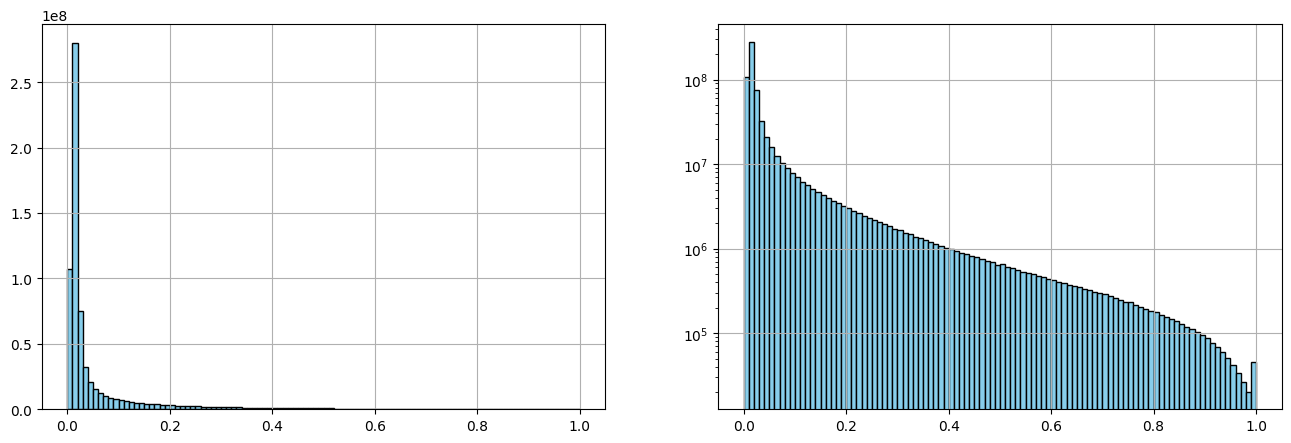

In [7]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(training_data.dataset.numpy().reshape(-1), bins=100, color="skyblue", edgecolor="black")
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(training_data.dataset.numpy().reshape(-1), bins=100, color="skyblue", edgecolor="black")
plt.yscale("log")
plt.grid()
plt.show()

In [9]:
try:
    print(f"mean = {training_data.mean.item()} std = {training_data.std.item()}")
except Exception as e:
    print(f"mean = {training_data.mean} std = {training_data.std}")

print(f"mean_ds  = {torch.mean(training_data.dataset).item()} std = {torch.std(training_data.dataset).item()}")
    

memory_after = psutil.virtual_memory()
print("")
print(f"RAM used : {format(memory_after.used)}, RAM free : {format(memory_after.free)}, memory used : {format(memory_after.used - memory_start.used)}")

mean = 0 std = 1
mean_ds  = 0.061692751944065094 std = 0.11726841330528259

RAM used : 87.39GB, RAM free : 214.81GB, memory used : 8.54GB


In [10]:
plot_size = math.ceil(math.sqrt(CONFIG.BATCH_SIZE))

x, y = next(iter(train_dataloader))
id2name = [v.split("/")[-1] for v in training_data.class_folders] 

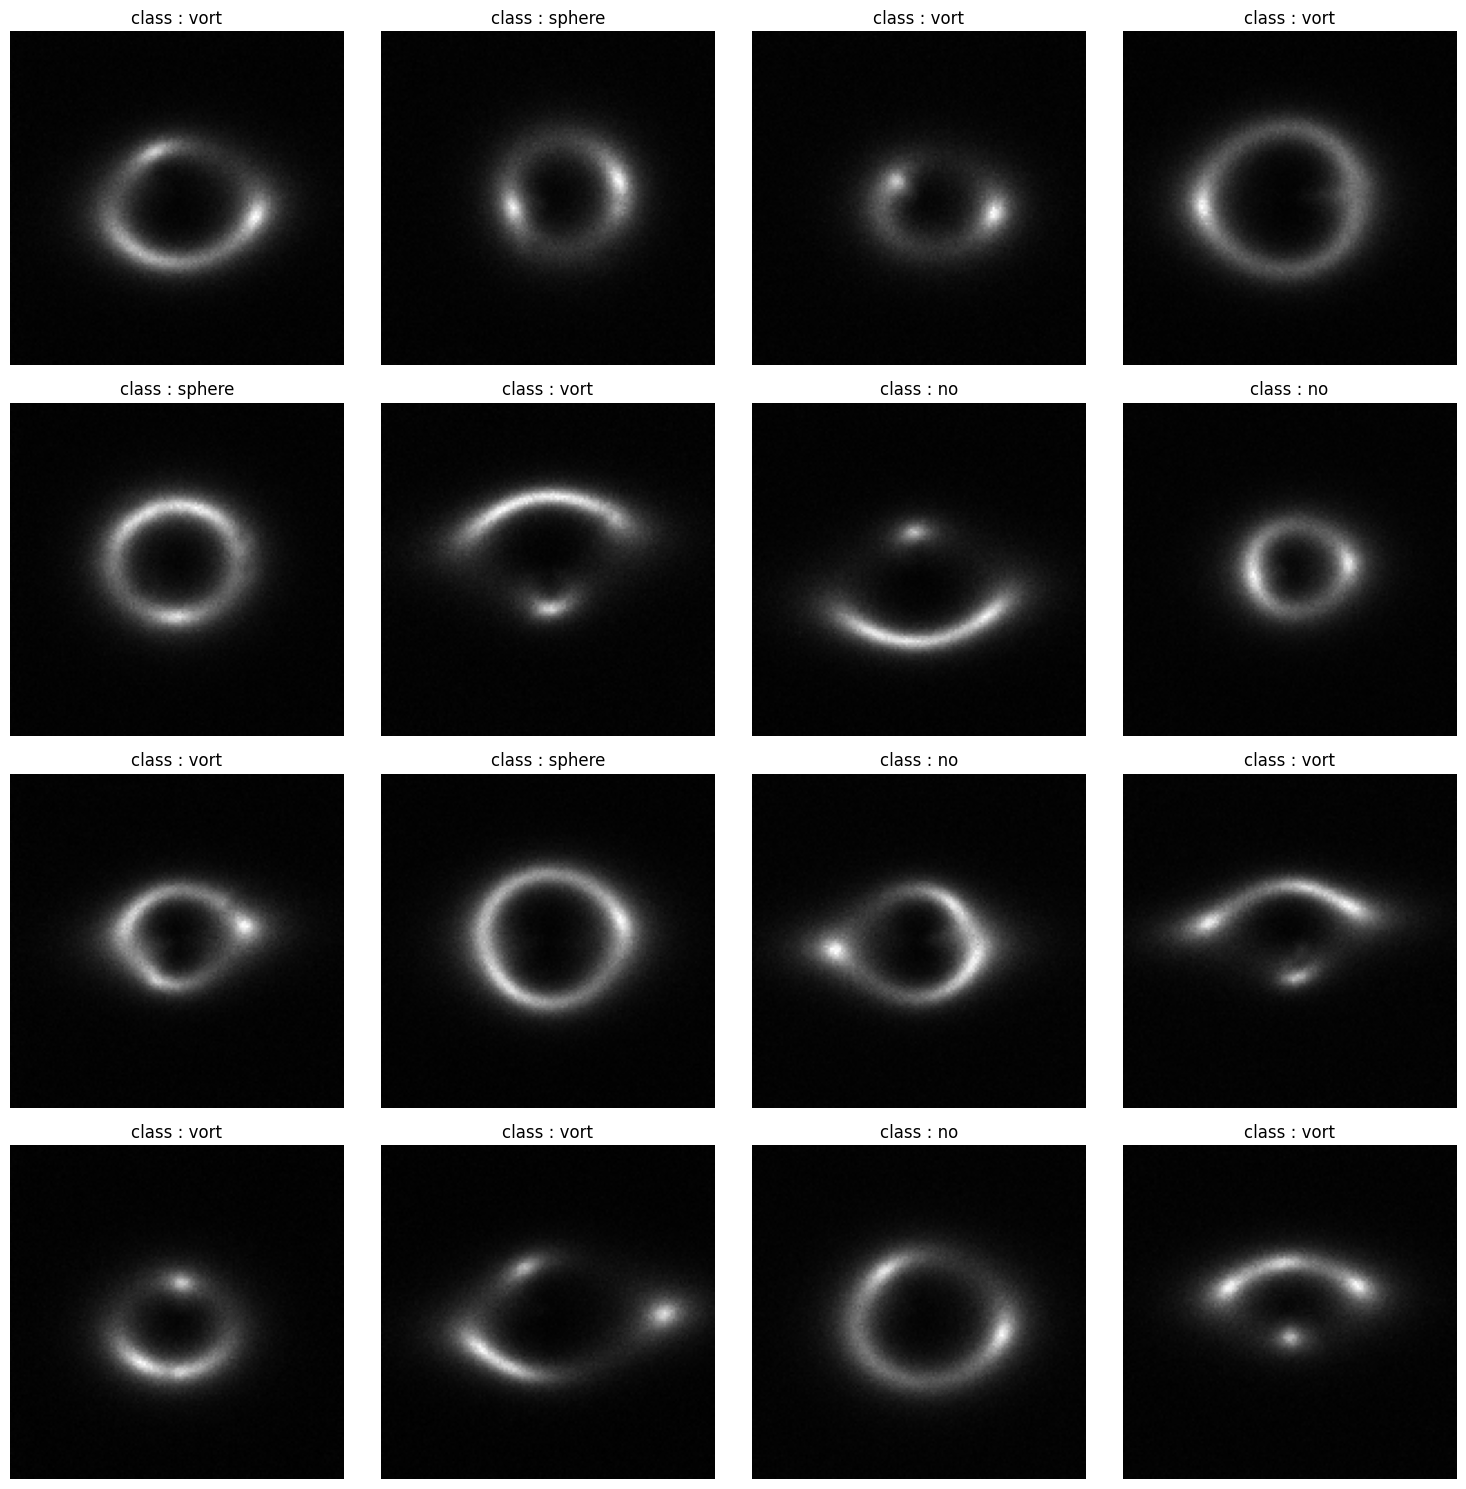

In [11]:
fig, axes = plt.subplots(plot_size, plot_size, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i >= len(x):
        break
    # Convert torch tensor to numpy array and transpose channels if necessary
    
    img = x[i].numpy().transpose(1, 2, 0)
    
    ax.imshow(img, cmap="gray")
    ax.set_title(f"class : {id2name[y[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Prototyping the train/val loop

## Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class CNNv1(nn.Module):
    def __init__(self):
        super(CNNv1, self).__init__()
        # the resnet model was trained on imagenet, it's not really applicable in this situation
        self.backend = resnet18(None)

        # make one channel 
        self.backend.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

        # output 3 classes
        self.backend.fc = nn.Linear(512, CONFIG.CLASSES, bias=True)
        

    def forward(self, x):
        # Applying convolutional layers with ReLU and pooling
        x = self.backend(x)
        return x

# Create the CNN model instance
model = CNNv1().to(CONFIG.DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [13]:
model(x.float().to(CONFIG.DEVICE)).shape

torch.Size([16, 3])

In [14]:
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

Layer (type:depth-idx)                        Param #
CNNv1                                         --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640
│    └─AdaptiveA

## Util function

In [15]:
def test(model : nn.Module, val_dataset : DataLoader,  run = None):
    
    # change the model to evaluation
    model.eval()
    
    # get the number of datapoints
    number_of_datapoints = len(val_dataset.dataset)    

    # allocate the memory for these datapoints (no need to keep appending the data, which will make it slower)
    predictions_prob = np.zeros((number_of_datapoints, CONFIG.CLASSES))
    predictions = np.zeros(number_of_datapoints)
    true_values = np.zeros(number_of_datapoints) 
    

    # get the number of batches
    dataset_len = len(val_dataset)

    # create the progreess bar 
    pbar = tqdm(val_dataset)

    # variable that will track where we are in terms of all data (after iteration add batch size to it)
    c = 0
    for i, (x,y) in enumerate(pbar): 
        # get the predictions
        pred = model(x.to(CONFIG.DEVICE))
 
        # get the batch size
        bs = x.shape[0]

        true_values[c : (c + bs)] = y.detach().numpy()
        predictions_prob[c : (c + bs)] = torch.softmax(pred.cpu().detach(), dim=1).numpy()
        predictions[c : (c + bs)] = torch.argmax(pred, 1).cpu().detach().numpy()
        c += bs 
           
        if i % (dataset_len//10) == 0 or i == dataset_len -1:
            acc = accuracy_score(predictions[:c], true_values[:c])
            try:
                roc_auc = roc_auc_score(true_values[:c], predictions_prob[:c, :], multi_class='ovr')            
            
            # It can happen at the beginning
            except Exception as e:
                roc_auc = 0

            pbar.set_description(f"examples seen so far : {c}, accuracy = {round(acc, CONFIG.ROUND_NUMBER)}, AUC ROC = {round(roc_auc, CONFIG.ROUND_NUMBER)}")
    
    return {"predition_prob" : predictions_prob, "predictions" : predictions, "true" : true_values}

def report_metrics(results : Dict, epoch : int, WANDB_ON : bool = True, prefix="val", run=None) -> Dict:
    predictions = results["predictions"]
    true_values = results["true"]
    predictions_prob = results["predition_prob"]
    
    acc = accuracy_score(predictions, true_values)
    roc_auc_ovr = roc_auc_score(true_values, predictions_prob, multi_class='ovr')            
    roc_auc_ovo = roc_auc_score(true_values, predictions_prob, multi_class='ovo')  
    
    if WANDB_ON:
        wandb.log({f"{prefix}_acc": acc, f"{prefix}_ROC_AUC_ovr": roc_auc_ovr, f"{prefix}_ROC_AUC_ovo" : roc_auc_ovo})
        wandb.log({f"{prefix}_ROC_epoch={epoch}" : wandb.plot.roc_curve(true_values, predictions_prob, labels=val_data.class_names)})
    
    return {"accuracy" : acc, "ROC_AUC_OVR" :  roc_auc_ovr, "ROC_AUC_OVO" : roc_auc_ovo}


def save_model(model : nn.Module, metrics_results : Dict, metric_keyword : str, best_metric : float, savepath : str):
    
    if metrics_results[metric_keyword] > best_metric:
        torch.save(model.state_dict(), savepath)
        
    return max(metrics_results[metric_keyword], best_metric)

def train(model : nn.Module, 
          optimizer : optim.Optimizer, 
          scheduler : lr_sched.LRScheduler, 
          criterion, 
          epoch : int, 
          WANDB_ON : bool=True):
    model.train()
    running_loss = 0.0
    i = 1
    train_len = len(train_dataloader)
    
    pb = tqdm(train_dataloader)
    for inputs, labels in pb:
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs.to(CONFIG.DEVICE))
        loss = criterion(outputs, labels.to(CONFIG.DEVICE))
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()  # Update learning rate
        
        running_loss += loss.item()
        
        if (i-1) % (train_len//10) == 0 or i == train_len:      
            pb.set_description(f"EPOCH : {epoch}, average loss : {running_loss / i}")
        i += 1
    
    if WANDB_ON:
        wandb.log({"loss" : running_loss/len(train_dataloader)})

    

def run_experiment(Model : nn.Module, 
                   run_name : str, 
                   model_parameters : dict, 
                   epochs : int, 
                   learning_rate : float, 
                   optimizer : str, 
                   savepath : str,
                   base_lr:float=1e-4, 
                   max_lr:float=1e-3, 
                   scheduler_en : bool = True,
                   metric_keyword : str = "acc",
                   lr_steps : int = 1000,
                   WANDB_ON : bool = True):

    try:
        os.mkdir("models") 
    except FileExistsError:
        pass
    
    model = Model(**model_parameters).to(CONFIG.DEVICE)
    
    config = {"model name" : model.__class__,
              "run name" : run_name,
              "epochs" : epochs,
              "learning rate" : learning_rate,
              "optimizer" : optimizer, 
              "uses scheduler" : scheduler_en,
              "base_lr" : base_lr,
              "max_lr" : max_lr,
              "lr_steps" : lr_steps}
    
    config.update(model_parameters)    
    
    model_summary_str = str(summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 150, 150)))
        
    if WANDB_ON:
        run = wandb.init(project=CONFIG.TASK_NAME,
                     name=f"experiment_{run_name}",
                     notes="Model summary : \n" + model_summary_str,
                     config=config)

    
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    if optimizer.lower() == "adam":
        optimizer_ = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer.lower() == "adamw":
        optimizer_ = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        raise Exception("specify correctly the optimizer !")

    # Set up CyclicLR scheduler
    scheduler = None
    if scheduler_en:
        scheduler = lr_sched.CyclicLR(optimizer_, base_lr=base_lr, max_lr=max_lr, step_size_up=lr_steps, mode='triangular')

    best_metric = 0 
    
    for epoch in range(epochs):
        train(model, optimizer_, scheduler, criterion, epoch=epoch, WANDB_ON=WANDB_ON)

        test_res = test(model, train_dataloader)
        evaluation = report_metrics(test_res, epoch=epoch, prefix="train", WANDB_ON=WANDB_ON)
        
        test_res = test(model, val_dataloader)
        evaluation = report_metrics(test_res, epoch=epoch, prefix="val", WANDB_ON=WANDB_ON)

        best_metric = save_model(model, evaluation, metric_keyword, best_metric, savepath)
    
    if WANDB_ON:
        wandb.finish()

## Run experiment

In [16]:
run_experiment(Model=CNNv1, 
               run_name="Simplest/testrun", 
               model_parameters={},
               epochs=30,
               learning_rate=1e-4,
               optimizer="Adam",
               savepath=os.path.join("models", "testrun.cfg"),
               base_lr=3e-4,
               max_lr=1e-3,
               scheduler_en=False,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

EPOCH : 0, average loss : 1.1144182132720948: 100%|██████████| 1875/1875 [00:23<00:00, 80.84it/s]
examples seen so far : 30000, accuracy = 0.341, AUC ROC = 0.537: 100%|██████████| 1875/1875 [00:05<00:00, 327.22it/s]
examples seen so far : 7500, accuracy = 0.336, AUC ROC = 0.519: 100%|██████████| 469/469 [00:01<00:00, 311.89it/s]
EPOCH : 1, average loss : 1.1005963306744893: 100%|██████████| 1875/1875 [00:23<00:00, 80.68it/s]
examples seen so far : 30000, accuracy = 0.365, AUC ROC = 0.559: 100%|██████████| 1875/1875 [00:05<00:00, 312.99it/s]
examples seen so far : 7500, accuracy = 0.351, AUC ROC = 0.544: 100%|██████████| 469/469 [00:01<00:00, 300.62it/s]
EPOCH : 2, average loss : 1.0663379144986471: 100%|██████████| 1875/1875 [00:23<00:00, 80.97it/s]
examples seen so far : 30000, accuracy = 0.334, AUC ROC = 0.59: 100%|██████████| 1875/1875 [00:05<00:00, 327.46it/s] 
examples seen so far : 7500, accuracy = 0.333, AUC ROC = 0.583: 100%|██████████| 469/469 [00:01<00:00, 300.57it/s]
EPOCH :